In [1]:
import main
import detection
import preprocessing as pp
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

import math

# Load Images

image array:
 [[197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 ...
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]]
num images loaded: 10


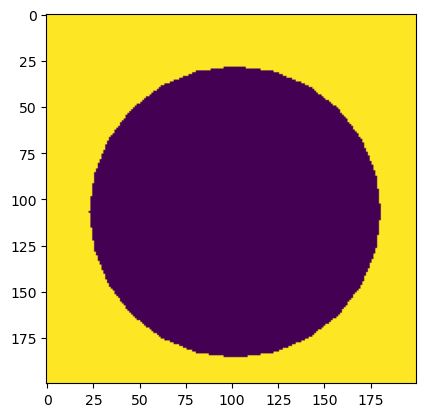

In [2]:
base_path = os.getcwd()

img_path = os.path.join(base_path, "data", "geometric shapes dataset", "Circle", "Circle_0a0b51ca-2a86-11ea-8123-8363a7ec19e6.png")

# cv2.imread does not work on linux, im using matlab for visualization
img_BGR = main.load_img(img_path, greyscale=False)
img = main.load_img(img_path)
print("image array:\n", img)
main.plt.imshow(img)

folder_path = os.path.join(base_path, 'data', 'geometric shapes dataset', 'Square')
data = main.load_img_from_folder(folder_path)
print("num images loaded:", len(data))


image shape: (200, 200)
lines detected:
[]


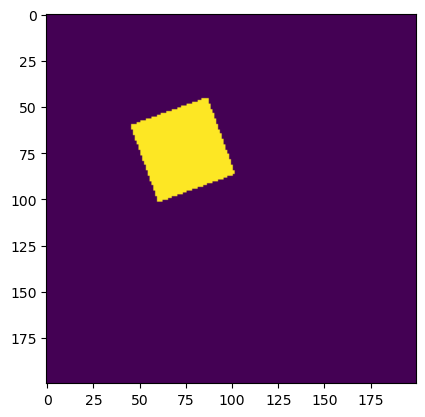

In [3]:
img = data[0]
print("image shape:", img.shape)
main.plt.imshow(img)
lines = detection.detect_line(img, canny_thres1=10, 
             canny_thres2=150, 
             rho=1, 
             theta=main.np.pi/180, 
             hough_thres=80, 
             min_line_len=30, 
             max_line_gap=10)
print("lines detected:")
print(lines)

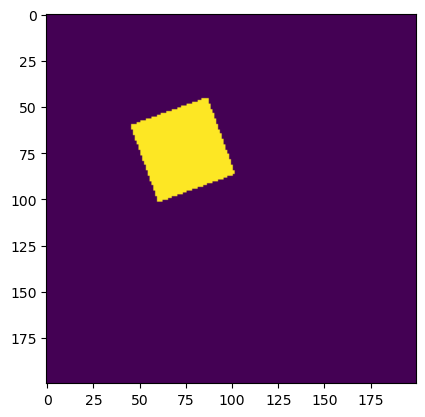

In [4]:
out = detection.draw_lines(img, lines)
main.plt.imshow(out)

# Test Edge Detection on Shapes

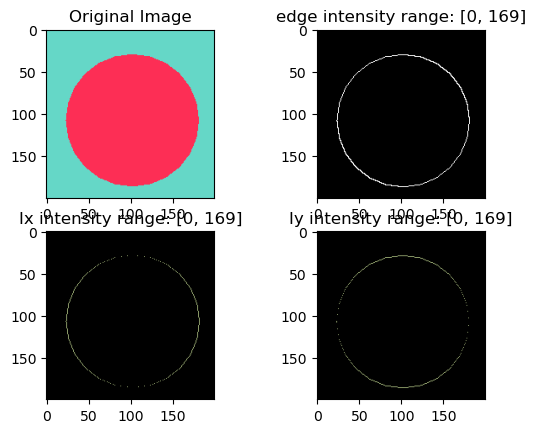

In [5]:
edges, Ix, Iy = pp.gradient(img_BGR, derv_len=1, use_sobel=False)

def show_edge_results(img, edges, Ix, Iy):

    def get_minmax(img):
        min = np.min(img)
        max = np.max(img)
        return min, max

    fig, ax = main.plt.subplots(2,2)
    ax[0,0].title.set_text("Original Image")
    ax[0,0].imshow(img)

    min, max = get_minmax(edges)
    ax[0,1].title.set_text(f"edge intensity range: [{min}, {max}]")
    ax[0,1].imshow(edges, cmap='gray', vmin=min, vmax=max)

    min, max = get_minmax(Ix)
    ax[1,0].title.set_text(f"Ix intensity range: [{min}, {max}]")
    ax[1,0].imshow(Ix, vmin=min, vmax=max)

    min, max = get_minmax(Iy)
    ax[1,1].title.set_text(f"Iy intensity range: [{min}, {max}]")
    ax[1,1].imshow(Iy, vmin=min, vmax=max)

show_edge_results(img_BGR, edges, Ix, Iy)

# Test Edge Detection on Physical Parts

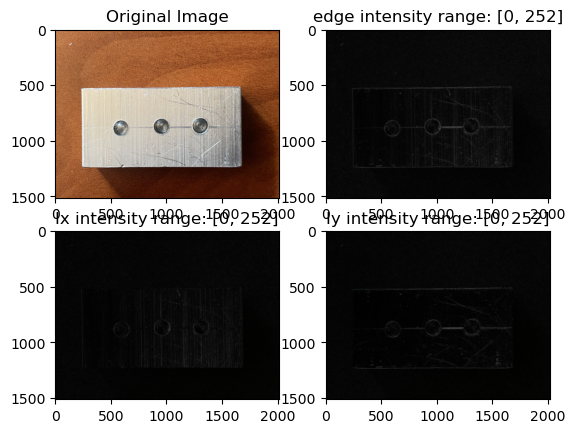

In [6]:
img_path = os.path.join(base_path, "data", "physical parts", "Basic II base part.jpg")



img_part1 = pp.crop(main.load_img(img_path, greyscale=False))


edges, Ix, Iy = pp.gradient(img_part1, derv_len=1, use_sobel=False)



show_edge_results(img_part1, edges, Ix, Iy)

# Test edge detection with denoising

Main Idea:
1. Take simple gradient of original image to get *fine edges*, which will have noisy details

2. Blur original image and take gradient of blurred image to get *rough edges*, which will inflate obvious edges and filter out noisy details

3. Use the *rough edges* as a mask to extract wanted details from *fine edges* to get *masked fine edges*, which should contain only details near wanted edges

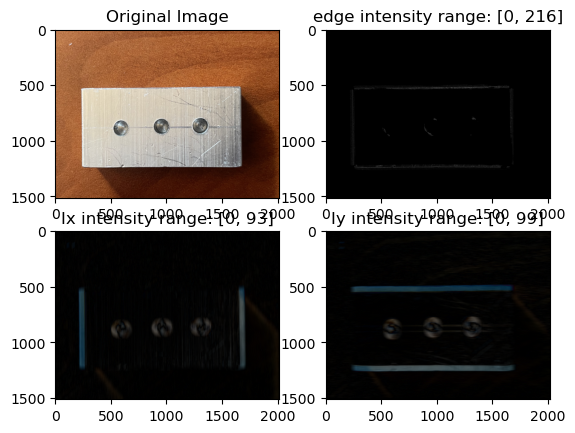

In [7]:
edges_masked, Ix, Iy = pp.getEdgesMasked(img_part1)

show_edge_results(img_part1, edges_masked, Ix, Iy)


# Run Hough Transform

TODO: Canny may not be necessary with our own edge detector

### A1: original -> Canny -> edges

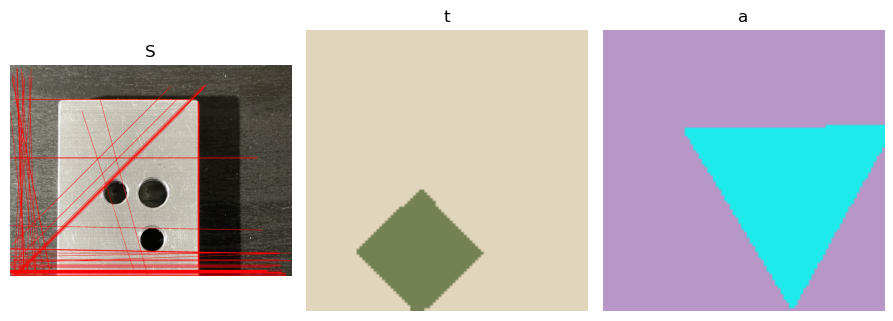

In [8]:

detection.subsample_technique(detection.DETECTION.LINE, "Standard A1 Hough Transform", lambda img: detection.applyHoughTransform(pp.crop(img)))

### A2: original -> Blur -> grad -> Threshold -> Canny -> edges

### A3: 
original -> grad ------------------> mask -> edges  
original -> blur -> grad -> thrs ->

In [9]:
# houghOutput = applyHoughTransform(edges_masked)
# showImage(houghOutput)

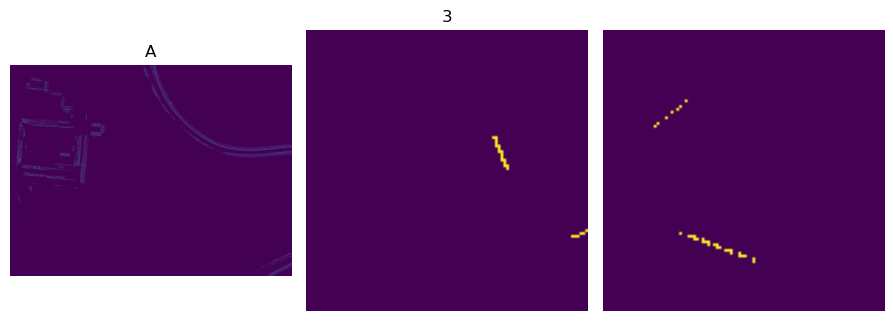

found 0 lines
found 0 lines


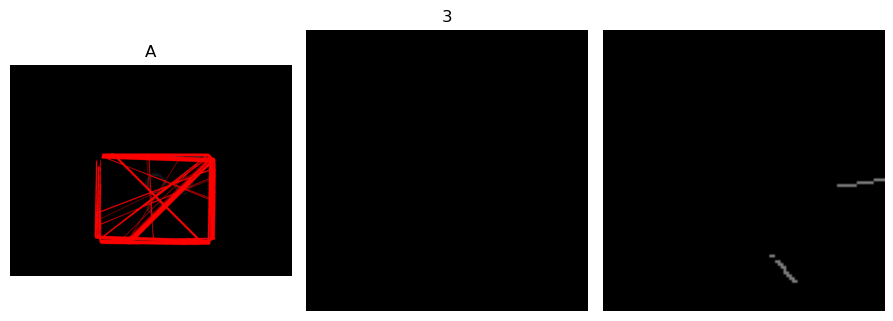

In [10]:
# APPROACH 3: first: org + FT + FLP -> LPF edges; then: LPF edge + Canny + HT
detection.subsample_technique(detection.DETECTION.LINE, "A3 Hough Transform", lambda img: pp.getEdgesMasked(pp.crop(img))[0])
detection.subsample_technique(detection.DETECTION.LINE, "A3 Hough Transform", lambda img: detection.find_lines(pp.getEdgesMasked(pp.crop(img))[0]))


### A4:
original -> grad ------------------> mask -> Canny -> edges  
original -> blur -> grad -> thrs ->


found 0 lines
found 0 lines


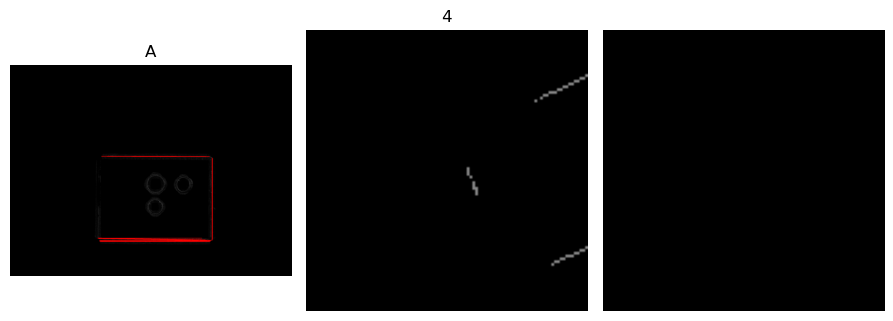

In [11]:
detection.subsample_technique(detection.DETECTION.LINE, "A4 Hough Transform", lambda img: detection.find_lines(pp.getEdgesMasked(pp.crop(img))[0], canny=True))

### General Insights in using HoughLinesP:
* Set maxLineGap to a large number to pick up long & continuous single lines
* Increase threshold to filter out short noisy lines
* Try not to set minLineLength too high, or actual features that are a bit short might be falsely ignored

### A5: original -> grad -> Canny -> edges

Total lines found: 1512


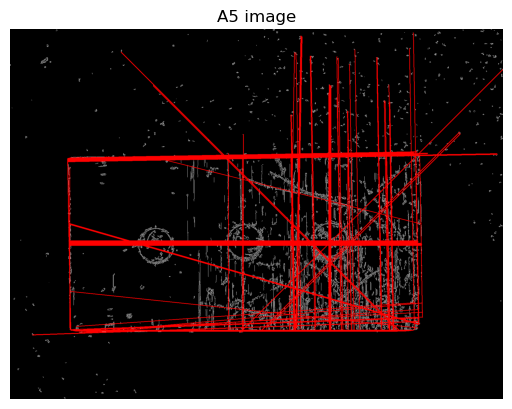

In [12]:
grad, _, _ = pp.gradient(img_part1)
# showImage(grad)
edges = cv2.Canny(grad, 50, 150)
# showImage(edges)

found_lines_A5 = detection.find_lines(edges)
#print total lines found
print('Total lines found:', len(found_lines_A5) if found_lines_A5 is not None else 0)
detection.display_single_image(found_lines_A5, "A5 image")

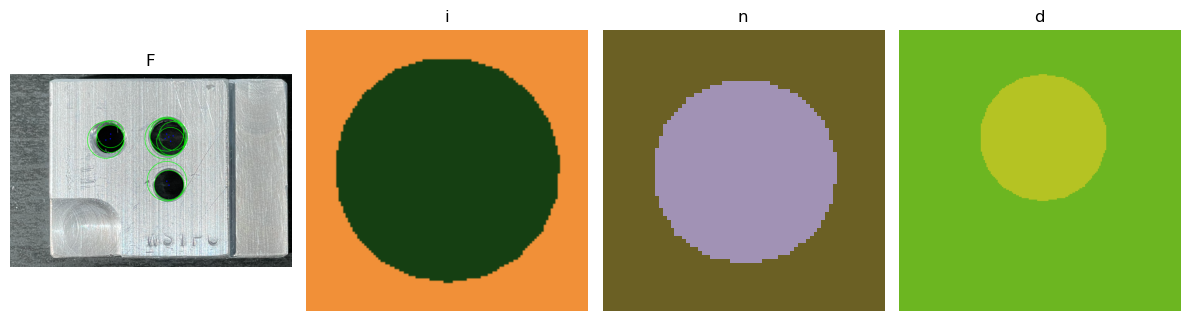

In [13]:


detection.subsample_technique(detection.DETECTION.CIRCLE, "Find Circles", lambda img: detection.find_circles(pp.crop_largest_structure(img)[0], blur=True, thresh=60, return_type="image"))


found 82 circles
found 0 circles
found 0 circles
found 0 circles


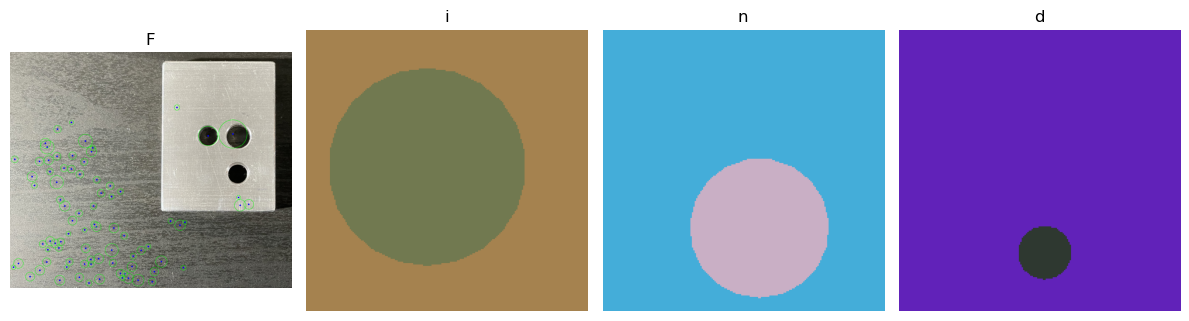

In [14]:

detection.subsample_technique(detection.DETECTION.CIRCLE, "Find Circle Contours", lambda img: detection.find_circles_contours(pp.crop_largest_structure(img)[0], filter=180))


found 62 circles
found 1 circles
found 1 circles
found 1 circles


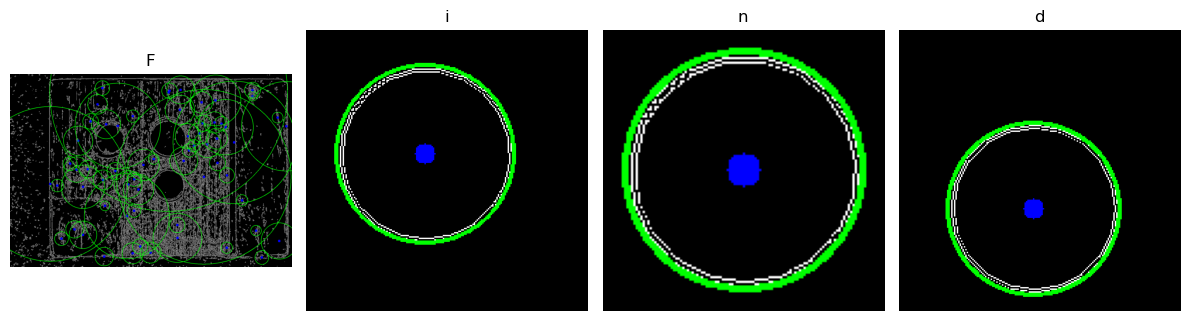

In [15]:
# grad, _, _ = pp.gradient(img_part1)
# # showImage(grad)
# edges = cv2.Canny(grad, 50, 150)
# # showImage(edges)

# found_circles_CT = find_circles_contours(edges, filter=60)
# showImage(found_circles_CT)

detection.subsample_technique(detection.DETECTION.CIRCLE, "Find Circle Contours + Canny", lambda img: detection.find_circles_contours(cv2.Canny(pp.gradient(pp.crop_largest_structure(img)[0])[0], 50, 150), filter=400))


# Ransac Circle Detection

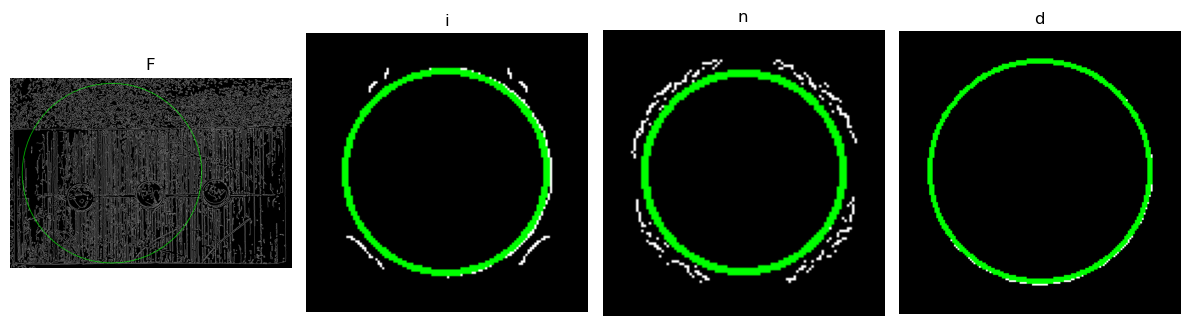

In [16]:

detection.subsample_technique(detection.DETECTION.CIRCLE, "Find Circle RANSAC", lambda img: detection.find_circle_ransac(pp.crop_largest_structure(img)[0]))


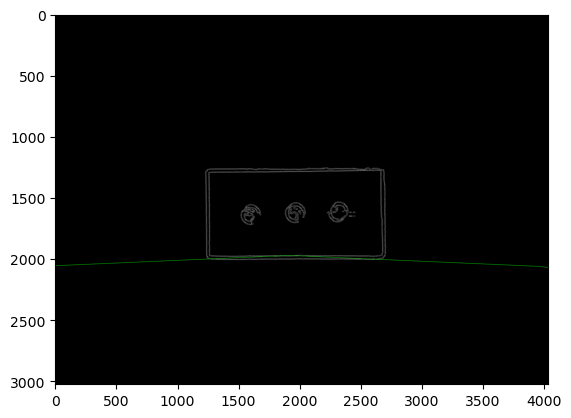

In [17]:
parts_path = os.path.join(base_path, "data", "physical parts")
img = os.path.join(parts_path, "Basic II base part.jpg")
img = main.load_img(img)
edges = pp.get_edges(img)
img_circles = detection.find_circle_ransac(edges)
plt.imshow(img_circles)

Base path: /Users/zack_szh/Desktop/EECS 442/EECS442_Final_Project


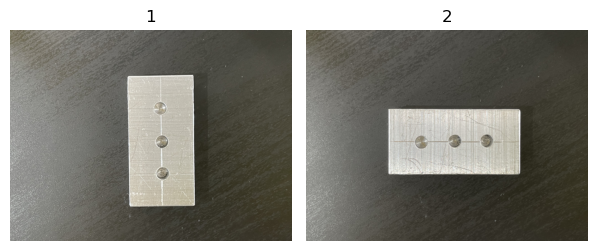

In [18]:
base_path = os.getcwd()
print("Base path:", base_path)
files = []

# parts_path = os.path.join(base_path, "data", "physical parts")
# files.append( os.path.join(parts_path, "Basic II base part.jpg") )
# files.append( os.path.join(parts_path, "mill part 2.jpeg") )
# files.append( os.path.join(parts_path, "servo mount 1.jpeg") )
# files.append( os.path.join(parts_path, "small PCB 2.jpeg") )

# parts_path = os.path.join(base_path, "data", "physical parts", "52mm 7in")
# img11 = os.path.join(parts_path, "Basic II base part 2.jpeg")
# img22 = os.path.join(parts_path, "mill part 2.jpeg")
# img33 = os.path.join(parts_path, "servo mount 1.jpeg")
# img44 = os.path.join(parts_path, "small PCB 2.jpeg")


parts_path = os.path.join(base_path, "data", "physical parts", "52mm 7in blk")
files.append( os.path.join(parts_path, "Basic II base part 1 thk0.50.jpeg") )
files.append( os.path.join(parts_path, "Basic II base part 2 thk0.50.jpeg") )
#files.append( os.path.join(parts_path, "servo mount 1 thk0.45.jpeg") )
#files.append( os.path.join(parts_path, "small PCB 2 thk0.06.jpeg") )

titles = [str(i) for i in range(1, len(files)+1)]

imgs = detection.show_images_from_files(files, titles)

## Feature Matching Visualization
This section derives edge points using preprocessing (`get_edges` if available), matches detected lines to edges, and overlays results using `features.visualize_matches`.

raw found_lines count: 42
[match_points_to_lines] detected_lines: 42, min_length: 50.0
  line ref=(804.0,1232.0,948.0,1232.0) len=144.0 matched=725
  line ref=(857.0,521.0,912.0,520.0) len=55.0 matched=222
  line ref=(1013.0,517.0,1109.0,516.0) len=96.0 matched=366
  line ref=(700.0,524.0,770.0,523.0) len=70.0 matched=282
  line ref=(677.0,877.0,771.0,877.0) len=94.0 matched=0
  line ref=(625.0,521.0,676.0,521.0) len=51.0 matched=260
  line ref=(1058.0,875.0,1123.0,875.0) len=65.0 matched=0
  line ref=(822.0,871.0,888.0,871.0) len=66.0 matched=25
  line ref=(1304.0,513.0,1367.0,512.0) len=63.0 matched=254
  line ref=(1040.0,873.0,1244.0,873.0) len=204.0 matched=0
  line ref=(445.0,1237.0,511.0,1236.0) len=66.0 matched=266
  line ref=(1500.0,512.0,1550.0,511.0) len=50.0 matched=178
  line ref=(723.0,520.0,785.0,520.0) len=62.0 matched=315
  line ref=(1562.0,929.0,1565.0,1051.0) len=122.0 matched=0
  line ref=(597.0,525.0,663.0,523.0) len=66.0 matched=267
  line ref=(527.0,521.0,618.0,52

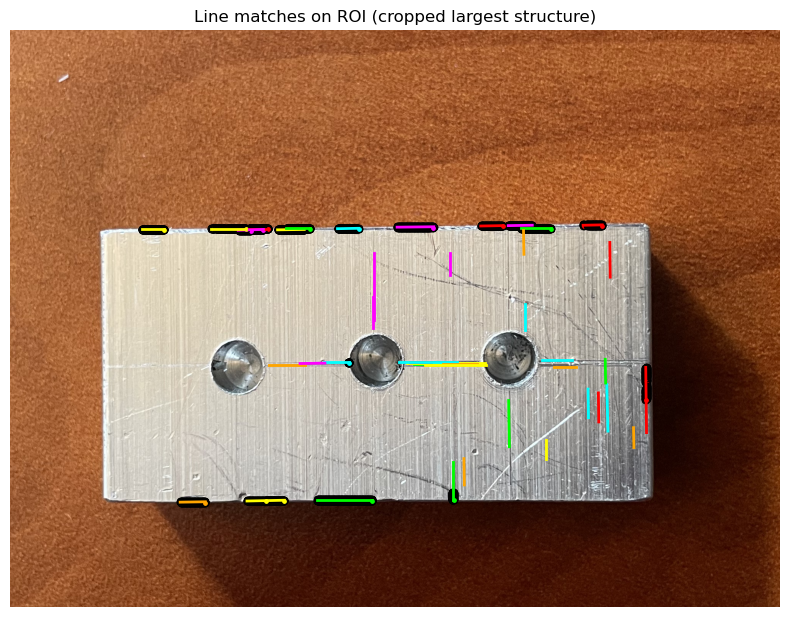

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Line matches on ROI (cropped largest structure)'}>)

In [19]:
from features import edge_points_from_image, match_points_to_lines, visualize_matches
import measurement
import numpy as np
import cv2

# Focus ROI to reduce clutter and false positives
# roi = pp.crop_largest_structure(img_part1)[0]
roi = img_part1

# Extract edge points from the ROI (same frame used for detection/matching)
edge_points = edge_points_from_image(roi)

# Detect lines with stricter parameters to reduce spurious segments
found_lines = detection.detect_line(
    roi,
    canny_thres1=120, canny_thres2=240,
    rho=1, theta=np.pi/180,
    hough_thres=300,           # higher accumulator threshold
    min_line_len=50,           # require longer segments
    max_line_gap=5             # avoid merging distant short fragments
)
print('raw found_lines count:', len(found_lines) if found_lines is not None else 0)

# Match points to lines with tuned thresholds for gradient+Canny edges.
line_features = match_points_to_lines(found_lines or [], edge_points, max_perp_dist=2.0, min_length=50.0)
print('Matched features (lines):', len(line_features))
for i, f in enumerate(line_features):
    print(f'  Line {i}: ref={f.ref} matched_pts={len(f.pts)}')

# Visualize overlays on ROI
visualize_matches(roi, line_features, title='Line matches on ROI (cropped largest structure)')

# Feature Matching Visualization 2
(John & Brandon)
1. Derive edge points using preprocessing (currently `get_edges` as temprary solution)
2. Detect lines using HT (similar to setup in testing_pp_generalization.ipynb)
3. Matches detected lines to edges, and overlays results using `features.visualize_matches`.

edge_points shaep: (43142, 2)
raw found_lines count: 106
[match_points_to_lines] detected_lines: 106, min_length: 50.0
  line ref=(242.0,1242.0,1665.0,1242.0) len=1423.0 matched=135
  line ref=(245.0,512.0,1683.0,512.0) len=1438.0 matched=2020
  line ref=(231.0,1227.0,1687.0,1227.0) len=1456.0 matched=1793
  line ref=(240.0,1241.0,1670.0,1241.0) len=1430.0 matched=236
  line ref=(233.0,516.0,1684.0,516.0) len=1451.0 matched=2825
  line ref=(231.0,1224.0,1690.0,1224.0) len=1459.0 matched=1795
  line ref=(231.0,1226.0,1689.0,1226.0) len=1458.0 matched=1778
  line ref=(237.0,514.0,1684.0,514.0) len=1447.0 matched=2309
  line ref=(235.0,1234.0,1681.0,1234.0) len=1446.0 matched=3299
  line ref=(232.0,1228.0,1685.0,1228.0) len=1453.0 matched=1842
  line ref=(230.0,520.0,1685.0,520.0) len=1455.0 matched=4131
  line ref=(228.0,522.0,1685.0,522.0) len=1457.0 matched=4280
  line ref=(234.0,515.0,1684.0,515.0) len=1450.0 matched=2561
  line ref=(232.0,1230.0,1682.0,1230.0) len=1450.0 matched=2574

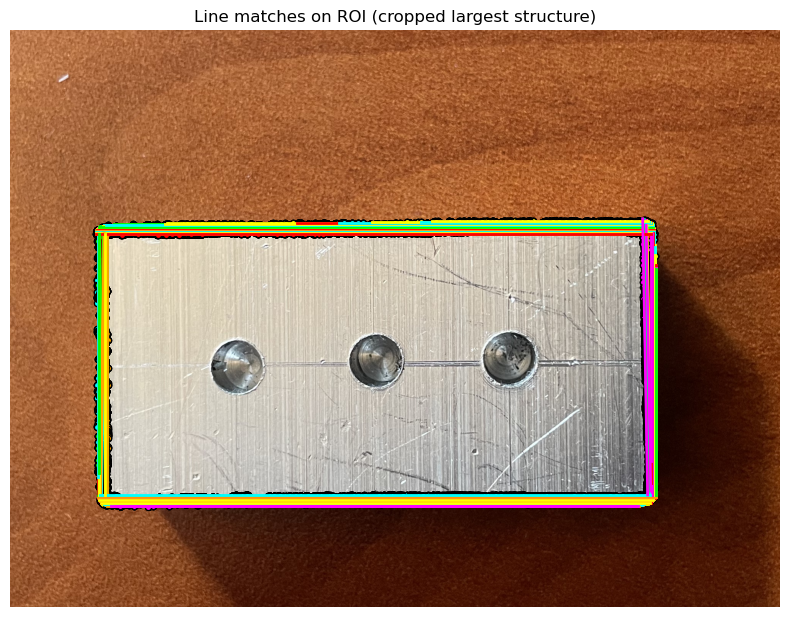

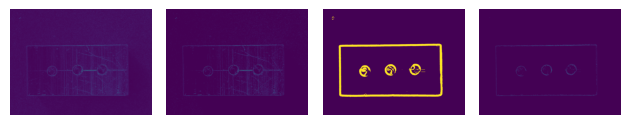

In [20]:
# 0. Get edge map
edges = pp.get_edges(img_part1)

# 1. Get edge points
# edge_points = edge_points_from_image(img_part1)
edge_points, egpt_interms = pp.get_edge_points(img_part1, edges, return_interm=True)
print("edge_points shaep:", edge_points.shape)

# 2. Detect lines using HT
found_lines = detection.find_lines_HT(edges)
print('raw found_lines count:', len(found_lines) if found_lines is not None else 0)

# 3. Match edge pts to detected lines
line_features = match_points_to_lines(found_lines, edge_points, max_perp_dist=2.0, min_length=50.0)

print('Matched features (lines):', len(line_features))
for i, f in enumerate(line_features):
    print(f'  Line {i}: ref={f.ref} matched_pts={len(f.pts)}')


# Visualize overlays on ROI
visualize_matches(roi, line_features, title='Line matches on ROI (cropped largest structure)')

# Visualize interms produced by pp.get_edge_points
plt.figure()
for i, im in enumerate(egpt_interms):
    plt.subplot(1, len(egpt_interms), i+1)
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()
plt.show()

edge_points shape: (78150, 2)
raw found_circles count: 0
[match_points_to_circles] detected_circles: 0, min_radius: 20.0
[match_points_to_circles] returning features: 0
Matched features (circles): 0


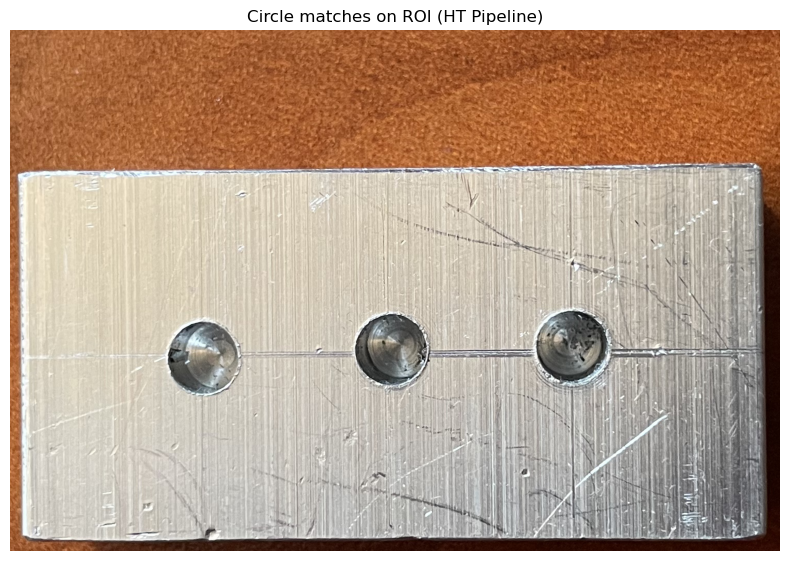

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Circle matches on ROI (HT Pipeline)'}>)

In [21]:
from features import edge_points_from_image, match_points_to_circles, visualize_matches
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Use cropped ROI like the reliable path
roi = pp.crop_largest_structure(img_part1)[0]

# Edge points derived from ROI for matching
edge_points = edge_points_from_image(roi)
print("edge_points shape:", edge_points.shape)

# Detect circles with tuned Hough params 
edges = pp.get_edges(roi)
found_circles = detection.find_circles(
    edges, blur=True, thresh=60, dp=1.2,
    minDist=20, param1=100, minRadius=20, maxRadius=0,
    return_type="circles"
 )
print('raw found_circles count:', len(found_circles) if found_circles is not None else 0)

# Match points to circle features
circle_features = match_points_to_circles(found_circles or [], edge_points, max_rad_diff=4.0, min_radius=20.0)
print('Matched features (circles):', len(circle_features))
for i, f in enumerate(circle_features):
    print(f'  Circle {i}: ref={f.ref} matched_pts={len(f.pts)}')

# Visualize overlays on ROI (hide circle points for clarity)
visualize_matches(roi, circle_features, title='Circle matches on ROI (HT Pipeline)', show_circle_points=False)

raw found_circles count: 3
[match_points_to_circles] detected_circles: 3, min_radius: 20.0
  circle ref=(737.0,621.0,r=70.0) matched=67
  circle ref=(374.0,635.0,r=69.0) matched=43
  circle ref=(1084.0,613.0,r=67.0) matched=19
[match_points_to_circles] returning features: 3
Matched features (circles): 3
  Circle 0: ref=(737.0, 621.0, 70.0) matched_pts=67
  Circle 1: ref=(374.0, 635.0, 69.0) matched_pts=43
  Circle 2: ref=(1084.0, 613.0, 67.0) matched_pts=19
[visualize_matches] drawing feature ref=(737.0, 621.0, 70.0)
[visualize_matches] drawing feature ref=(374.0, 635.0, 69.0)
[visualize_matches] drawing feature ref=(1084.0, 613.0, 67.0)


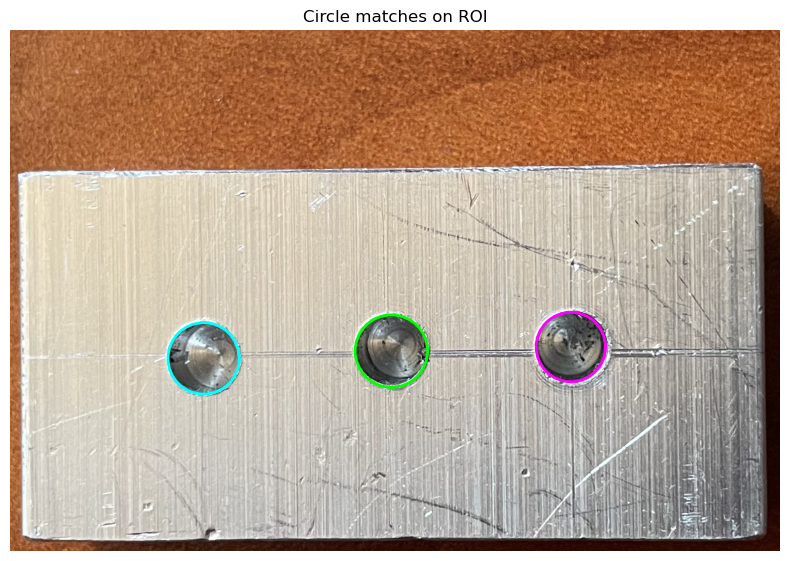

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Circle matches on ROI'}>)

In [22]:
from features import edge_points_from_image, match_points_to_circles, visualize_matches
import numpy as np
import cv2

# Reuse ROI to keep consistent coordinates
roi = pp.crop_largest_structure(img_part1)[0]

# Edge points derived from ROI for matching
edge_points = edge_points_from_image(roi)

# Prepare grayscale + blur for robust HoughCircles
gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) if roi.ndim==3 else roi
gray_blur = cv2.medianBlur(gray, 17)

# Detect circles (parameters tuned for larger, clearer features)
circles_raw = cv2.HoughCircles(
    gray_blur, cv2.HOUGH_GRADIENT,
    dp=1.2, minDist=20,
    param1=100, param2=60,
    minRadius=20, maxRadius=0
)
found_circles = []
if circles_raw is not None:
    circles = np.round(circles_raw[0, :]).astype(int)
    found_circles = [tuple(c) for c in circles]
print('raw found_circles count:', len(found_circles))

# Match points to circle features 
circle_features = match_points_to_circles(found_circles, edge_points, max_rad_diff=4.0, min_radius=20.0)
print('Matched features (circles):', len(circle_features))
for i, f in enumerate(circle_features):
    print(f'  Circle {i}: ref={f.ref} matched_pts={len(f.pts)}')

# Visualize overlays on ROI
visualize_matches(roi, circle_features, title='Circle matches on ROI')

raw found_circles count: 0
[match_points_to_circles] detected_circles: 0, min_radius: 20.0
[match_points_to_circles] returning features: 0
Matched features (circles): 0


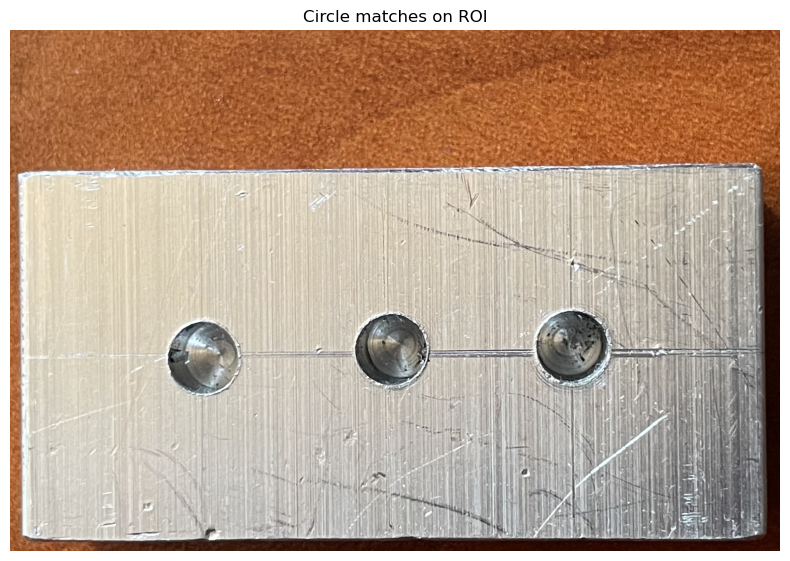

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Circle matches on ROI'}>)

In [23]:
from features import edge_points_from_image, match_points_to_circles, visualize_matches
import numpy as np
import cv2

# Reuse ROI to keep consistent coordinates
roi = pp.crop_largest_structure(img_part1)[0]

# Edge points derived from ROI for matching
edge_points = edge_points_from_image(roi)

# find circles
edges = pp.get_edges(roi)
found_circles = detection.find_circles_HT(edges)
print('raw found_circles count:', len(found_circles))

# Match points to circle features 
circle_features = match_points_to_circles(found_circles, edge_points, max_rad_diff=4.0, min_radius=20.0)
print('Matched features (circles):', len(circle_features))
for i, f in enumerate(circle_features):
    print(f'  Circle {i}: ref={f.ref} matched_pts={len(f.pts)}')

# Visualize overlays on ROI
visualize_matches(roi, circle_features, title='Circle matches on ROI')

### Measurement Testing ###
(zack) 


[match_points_to_circles] detected_circles: 3, min_radius: 20.0
  circle ref=(737.0,621.0,r=70.0) matched=67
  circle ref=(374.0,635.0,r=69.0) matched=43
  circle ref=(1084.0,613.0,r=67.0) matched=19
[match_points_to_circles] returning features: 3
Matched features (circles): 3
Radius: 70.0, Circularity: 1.5803806508588072
Radius: 69.0, Circularity: 1.3764887517504931
Radius: 67.0, Circularity: 1.2425172201755597
[visualize_matches] drawing feature ref=(737.0, 621.0, 70.0)
[visualize_matches] drawing feature ref=(374.0, 635.0, 69.0)
[visualize_matches] drawing feature ref=(1084.0, 613.0, 67.0)


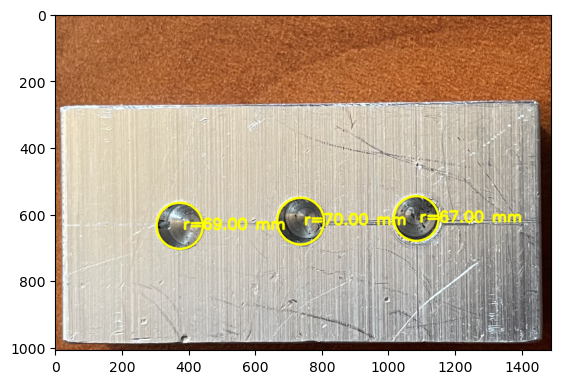

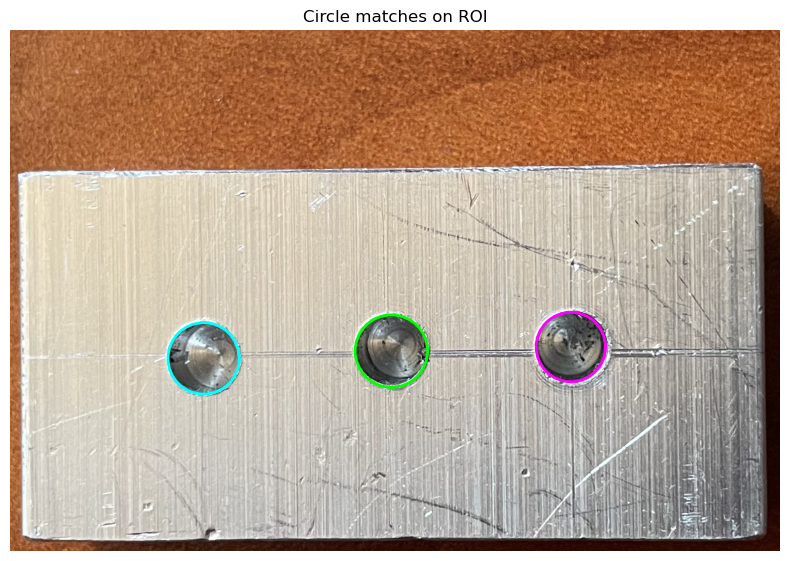

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Circle matches on ROI'}>)

In [24]:
# first need line and circle features detected and matched

# CIRCLE
import features
from features import edge_points_from_image, match_points_to_circles, visualize_matches
import numpy as np
import cv2

# Reuse ROI to keep consistent coordinates
roi = pp.crop_largest_structure(img_part1)[0]
out = roi.copy()

# Edge points derived from ROI for matching
edge_points = edge_points_from_image(roi)

# Prepare grayscale + blur for robust HoughCircles
gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) if roi.ndim==3 else roi
gray_blur = cv2.medianBlur(gray, 17)

# Detect circles (parameters tuned for larger, clearer features)
circles_raw = cv2.HoughCircles(
    gray_blur, cv2.HOUGH_GRADIENT,
    dp=1.2, minDist=20,
    param1=100, param2=60,
    minRadius=20, maxRadius=0
)
found_circles = []
if circles_raw is not None:
    circles = np.round(circles_raw[0, :]).astype(int)
    found_circles = [tuple(c) for c in circles]

circle_features = match_points_to_circles(found_circles, edge_points, max_rad_diff=4.0, min_radius=20.0)
print('Matched features (circles):', len(circle_features))
for i in circle_features: 
    print(f"Radius: {i.measure_radius()}, Circularity: {i.measure_circularity()}")
    out = i.draw_circle_measurement(out)

plt.imshow(out)
visualize_matches(roi, circle_features, title='Circle matches on ROI')




[match_points_to_lines] detected_lines: 106, min_length: 50.0
  line ref=(242.0,1242.0,1665.0,1242.0) len=1423.0 matched=135
  line ref=(245.0,512.0,1683.0,512.0) len=1438.0 matched=2020
  line ref=(231.0,1227.0,1687.0,1227.0) len=1456.0 matched=1793
  line ref=(240.0,1241.0,1670.0,1241.0) len=1430.0 matched=236
  line ref=(233.0,516.0,1684.0,516.0) len=1451.0 matched=2825
  line ref=(231.0,1224.0,1690.0,1224.0) len=1459.0 matched=1795
  line ref=(231.0,1226.0,1689.0,1226.0) len=1458.0 matched=1778
  line ref=(237.0,514.0,1684.0,514.0) len=1447.0 matched=2309
  line ref=(235.0,1234.0,1681.0,1234.0) len=1446.0 matched=3299
  line ref=(232.0,1228.0,1685.0,1228.0) len=1453.0 matched=1842
  line ref=(230.0,520.0,1685.0,520.0) len=1455.0 matched=4131
  line ref=(228.0,522.0,1685.0,522.0) len=1457.0 matched=4280
  line ref=(234.0,515.0,1684.0,515.0) len=1450.0 matched=2561
  line ref=(232.0,1230.0,1682.0,1230.0) len=1450.0 matched=2574
  line ref=(234.0,1233.0,1681.0,1233.0) len=1447.0 match

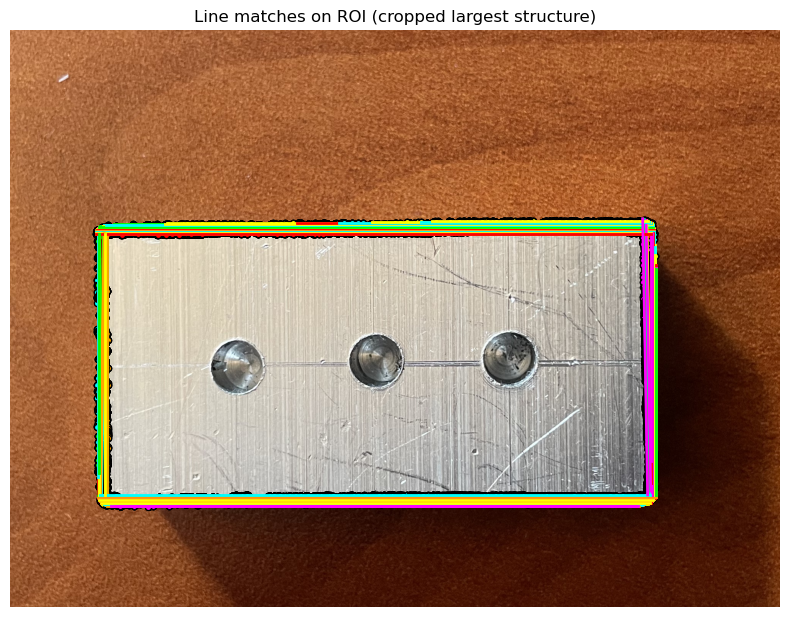

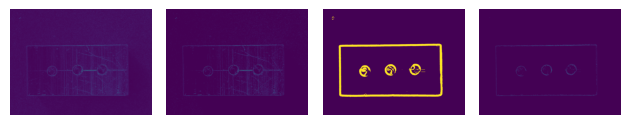

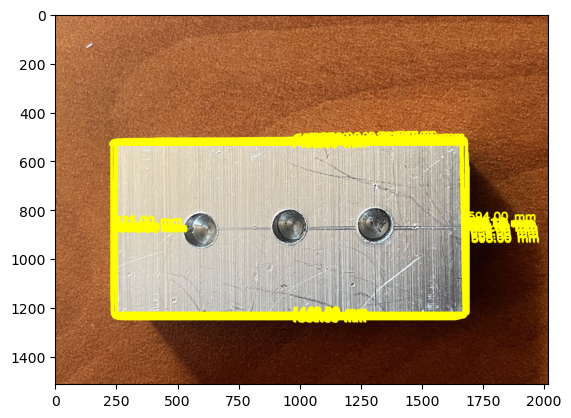

In [28]:
# Line Measurement

import features
edges = pp.get_edges(img_part1)

plt.close()
out = img_part1.copy()
# 1. Get edge points
# edge_points = edge_points_from_image(img_part1)
edge_points, egpt_interms = pp.get_edge_points(img_part1, edges, return_interm=True)
#print("edge_points shaep:", edge_points.shape)

# 2. Detect lines using HT
found_lines = detection.find_lines_HT(edges)
#print('raw found_lines count:', len(found_lines) if found_lines is not None else 0)

# 3. Match edge pts to detected lines
line_features = match_points_to_lines(found_lines, edge_points, max_perp_dist=2.0, min_length=50.0)

for i in line_features: 
    print(f"Length: {i.measure_length()}, Straightness: {i.measure_straightness()}")
    out = i.draw_line_measurement(out)

visualize_matches(img_part1, line_features, title='Line matches on ROI (cropped largest structure)')

# Visualize interms produced by pp.get_edge_points
plt.figure()
for i, im in enumerate(egpt_interms):
    plt.subplot(1, len(egpt_interms), i+1)
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure()
plt.imshow(out)


In [ ]:
# with proper line filtering 

import detection
# Load an example image
f_get_edges = pp.get_edges
# f_get_edges = pp.get_edges_2

f_find_lines = detection.find_lines_HT
f_find_circles = detection.find_circles_HT
# f_find_circles = detection.find_circles

f_filter_lines = detection.filter_lines
f_filter_circles = detection.filter_circles
base_path = os.getcwd()
parts_path = os.path.join(base_path, "data", "physical parts")
img_path = os.path.join(parts_path, "Basic II base part.jpg")
#img_path = os.path.join(parts_path, "mill part 2.jpeg")
img = main.load_img(img_path, greyscale=False)

# Use consistent detection methods as specified
f_find_lines = detection.find_lines_HT
f_find_circles = detection.find_circles_HT

# Use ROI (optional) to reduce clutter
roi = pp.crop_largest_structure(img)[0] if hasattr(pp, "crop_largest_structure") else img
roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) if roi.ndim == 3 else roi

# 1) Preprocessing: edges
edges, interms = f_get_edges(roi, return_interm=True)

# 2) Detection (using consistent methods)
lines_raw = f_find_lines(edges)
circles_raw = f_find_circles(edges)
# Normalize circles to list for filtration
if circles_raw is None:
    circles_raw = []
elif isinstance(circles_raw, np.ndarray):
    circles_raw = circles_raw.tolist()
print("raw lines:", len(lines_raw) if lines_raw is not None else 0)
print("raw circles:", len(circles_raw))

# 3) Filtering (use detection module functions)
lines_f = f_filter_lines(lines_raw)
H, W = roi_gray.shape[:2]
circles_f, fake_canvas = f_filter_circles(edges, circles_raw, H, W)
print("filtered lines:", len(lines_f))
print("filtered circles:", len(circles_f))

# visualization on edges
edges_gray = edges if edges.ndim==2 else cv2.cvtColor(edges, cv2.COLOR_BGR2GRAY)
img_lines_final = draw_lines_circles(edges_gray, lines_f, [], thickness=5)
img_circles_final = draw_lines_circles(edges_gray, [], circles_f, thickness=5)

# 4) Matching edge points to features
edge_points, egpt_interm = pp.get_edge_points(roi, edges, return_interm=True)
line_features = match_points_to_lines(lines_f, edge_points, max_perp_dist=2.0, min_length=50.0)
circle_features = match_points_to_circles(circles_f, edge_points, max_rad_diff=4.0, min_radius=20.0)
print("line feature objects:", len(line_features))
print("circle feature objects:", len(circle_features))

# 5) Measurement using feature objects' built-in methods (matching Zack's approach)
measurement_output = roi.copy()

# Line measurements - print and draw on image (like Zack's approach)
for i, lf in enumerate(line_features):
    length = lf.measure_length()
    straightness = lf.measure_straightness()
    print(f"Line {i+1}: Length: {length:.2f}, Straightness: {straightness:.4f}")
    measurement_output = lf.draw_line_measurement(measurement_output)

# Circle measurements - print and draw on image (like Zack's approach)
for i, cf in enumerate(circle_features):
    radius = cf.measure_radius()
    circularity = cf.measure_circularity()
    print(f"Circle {i+1}: Radius: {radius:.2f}, Circularity: {circularity:.4f}")
    measurement_output = cf.draw_circle_measurement(measurement_output)

# Visualize matches using features.visualize_matches (like Zack's approach)
try:
    from features import visualize_matches
    if line_features:
        visualize_matches(roi, line_features, title='Line matches on filtered results')
    if circle_features:
        visualize_matches(roi, circle_features, title='Circle matches on filtered results', show_circle_points=False)
except ImportError:
    print("visualize_matches not available, skipping visualization")

# Show edge point processing intermediates (like Zack's approach)
if 'egpt_interm' in locals() and egpt_interm:
    plt.figure(figsize=(15, 3))
    for i, im in enumerate(egpt_interm):
        plt.subplot(1, len(egpt_interm), i+1)
        plt.imshow(im)
        plt.axis('off')
    plt.suptitle("Edge Point Processing Steps")
    plt.tight_layout()
    plt.show()

# Show consistent visuals with Zack's measurement style
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(img_lines_final)
plt.title("Filtered Lines")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_circles_final)
plt.title("Filtered Circles")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(measurement_output)
plt.title("Feature Measurements")
plt.axis('off')
plt.tight_layout()
plt.show()

# Display final measurement output
plt.figure(figsize=(8, 4))
plt.imshow(measurement_output)
plt.title("Final Measurements Overlaid")
plt.axis('off')
plt.show()